In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Calendar

In [3]:
calendar = pd.DataFrame({"date": pd.date_range('2018-01-01', '2020-12-31')}) #-- dia anterior menos a janela
# calendar["Day"] = calendar.Date.dt.weekday_name
# calendar["Week"] = calendar.Date.dt.weekofyear
# calendar["Quarter"] = calendar.Date.dt.quarter
# calendar["Year"] = calendar.Date.dt.year
# calendar["Year_half"] = (calendar.Quarter + 1) // 2

# Stocks

In [5]:
from fenix_alpha_vantage_interface.alpha_stock_timeseries import AlphaStockTimeSeries
# Instance of class to use
timeseries = AlphaStockTimeSeries()

In [6]:
to_consider = ['ABEV3.SAO', 
               'LREN3.SAO',
               'AZUL4.SAO', 
               'LIGT3.SAO',
               'SHOW3.SAO',
               'PETR4.SAO',
               'JBSS3.SAO',
               'OIBR3.SAO',
               'BBDC4.SAO',
               'NTCO3.SAO']

# to_consider = ['BBAS3.SAO', 'BBDC4.SAO',
#                'BPAC11.SAO', 'ITUB4.SAO',
#                'SHOW3.SAO']

### Getting data from Alpha Vantage

In [7]:
daily_api_dfs = {}
for ticker in to_consider:
    daily_api_dfs[ticker] = timeseries.df_time_series_daily(ticker=ticker, use_vpn=True, adjusted=True)

INFO:root:Starting API Interface with Endpoint: TIME_SERIES_DAILY_ADJUSTED
INFO:root:Using VPN to call Alpha Vantage! Be aware that this is a 3rd party service which can malfunction sometimes due to connection timeout. If it does, try your command again.
INFO:root:Starting API Interface with Endpoint: TIME_SERIES_DAILY_ADJUSTED
INFO:root:Using VPN to call Alpha Vantage! Be aware that this is a 3rd party service which can malfunction sometimes due to connection timeout. If it does, try your command again.
INFO:root:Starting API Interface with Endpoint: TIME_SERIES_DAILY_ADJUSTED
INFO:root:Using VPN to call Alpha Vantage! Be aware that this is a 3rd party service which can malfunction sometimes due to connection timeout. If it does, try your command again.
INFO:root:Starting API Interface with Endpoint: TIME_SERIES_DAILY_ADJUSTED
INFO:root:Using VPN to call Alpha Vantage! Be aware that this is a 3rd party service which can malfunction sometimes due to connection timeout. If it does, try 

## Single Dataframe calculating return over week

In [12]:
# Using data for 2 years
df = calendar.copy()
daily_dfs = daily_api_dfs.copy()

ticker_close_column_names = []
close_column_name = 'close'

for stock in daily_dfs:
    
    # Getting Stock name
    prefix = stock.lower()[0:5]+'_'
    
    #Selecting only the columns of interest and renaming
    daily_dfs[stock] = daily_dfs[stock][['timestamp', 'adjusted_close']]
    daily_dfs[stock] = daily_dfs[stock].rename({'adjusted_close':close_column_name}, axis='columns')
    
    # Adding Prefix to all columns
    daily_dfs[stock] = daily_dfs[stock].add_prefix(prefix)
    ticker_close_column_names.append(prefix+close_column_name)
    
    df = df.merge(daily_dfs[stock], how='inner', left_on='date', right_on=prefix+'timestamp')
    del df[prefix+'timestamp']
    
df = df.set_index('date')

# Different kinds of Return

How to choose?

shifting_test = df.copy()
for ticker_close in ticker_close_column_names: 
    shifting_test[ticker_close+'_previous_day_close'] = shifting_test[ticker_close].shift(1)

In [44]:
print("(stock price / previous stock price) - 1")
# (((df/df.shift(1))-1)*100).head() -> Aqui é a janela de retorno
returns_window = 1
returns = df.pct_change(periods=returns_window)
returns.head()

(stock price / previous stock price) - 1


,abev3_close,lren3_close,azul4_close,ligt3_close,show3_close,petr4_close,jbss3_close,oibr3_close,bbdc4_close,ntco3_close
date,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.002307921006616376160889305,0.012730027165574337092152993,-0.0033149171270718232044198895,-0.0160825612875984203074936042,0.005438169149719594403217583,0.009067043618739903069466882,-0.0217752799528500463079902332,-0.0277777777777777777777777778,0.004045279940170649624366863,-0.0080410851128415757553230373
2018-01-04,-0.0055202232221412231970035947,0.005584899401640703741978286,0.006282335550628233555062823,-0.0072639377989826700493518624,0,0.001794445889785000033354013,0.002022658073956125533906420,-0.0057142857142857142857142857,0.016406129082185420213589228,0.029958219618668148860563442
2018-01-05,0.003700576824884862517504436,-0.0061089525017841566886051859,-0.0011017260374586852735952993,-0.0024411486112788694430494015,0.006760944278550904276297256,0.005979650543362454719795440,0.008074300746228592902775541,0.005747126436781609195402299,0.005667542256738236637734125,0
2018-01-08,-0.0018434665229501508519736676,-0.0050327270870499028240077358,-0.0106617647058823529411764706,-0.0103875247739279500888993685,0.013417091051541776260562986,0.011881594450401789851331136,0.002002407149019566074110367,-0.0114285714285714285714285714,-0.0002839094328909078004116687,-0.0118178510793111811787533350


# Standardizing Return Values

In [167]:
# Average return window -> Aqui é a janela de trade
average_return_window = 30

average_return_df = returns.rolling(average_return_window).mean()

In [ ]:
# Log return (Not being used)
# log_returns = np.log(returns.astype(float))
# log_returns.head()

# Returns Covariance

In [111]:
returns_covariance_matrix = returns.astype(float).cov() # Sim, é só isso haha

# Portfolio Optimization

In [55]:
# solve with SciPy
import scipy.optimize as sop

In [59]:
# Ponto de atencao
def check_sum_to_one(weights):
    return np.sum(weights)-1

def check_inequality(weights):
    return weights

In [74]:
# Starting values -> Fazer mais dinamico
weights_start = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Can be anywhere from 0 to 1 -> We can set our hardcoded % of a stock here
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

In [79]:
# Constraints from our minimization
constraints = ([
    {'type':'eq', 'fun':check_sum_to_one},
    {'type':'ineq', 'fun':check_inequality}
])

In [163]:
def negative_sr(weights):
    weights = np.array(weights)
    
    ret = np.sum(average_return_df[-1:].mean()*weights)
    volatility = np.dot(weights.T, np.dot(returns_covariance_matrix, weights))
    
    sr = volatility/ret
    return sr

In [164]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
optimal_weights = sop.minimize(fun=negative_sr,
                               x0=weights_start, 
                               method='SLSQP',
                               bounds=bounds,
                               constraints=constraints
                              )

In [165]:
optimal_weights

     fun: 0.05583242774879928
     jac: array([0.05567885, 0.09882839, 0.10218638, 0.07690731, 0.05576541,
       0.05602656, 0.05580024, 0.0563741 , 0.05788919, 0.07216592])
 message: 'Optimization terminated successfully'
    nfev: 132
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([2.58262423e-01, 3.45996018e-17, 0.00000000e+00, 0.00000000e+00,
       3.79527954e-01, 7.88046055e-02, 1.80726867e-01, 1.02678151e-01,
       0.00000000e+00, 0.00000000e+00])

In [166]:
print("Optimal Allocation")
print("")
for ticker, value in zip(ticker_close_column_names, list(optimal_weights.x.astype(float)*100)):
    print(f'{ticker[:5]} - {round(value,3)}%')

Optimal Allocation

abev3 - 25.826%
lren3 - 0.0%
azul4 - 0.0%
ligt3 - 0.0%
show3 - 37.953%
petr4 - 7.88%
jbss3 - 18.073%
oibr3 - 10.268%
bbdc4 - 0.0%
ntco3 - 0.0%


---

# Correlation

In [51]:
import seaborn as sns
from matplotlib import pyplot as plt

In [151]:
correlation_matrix = average_return_df.corr()

<AxesSubplot:>

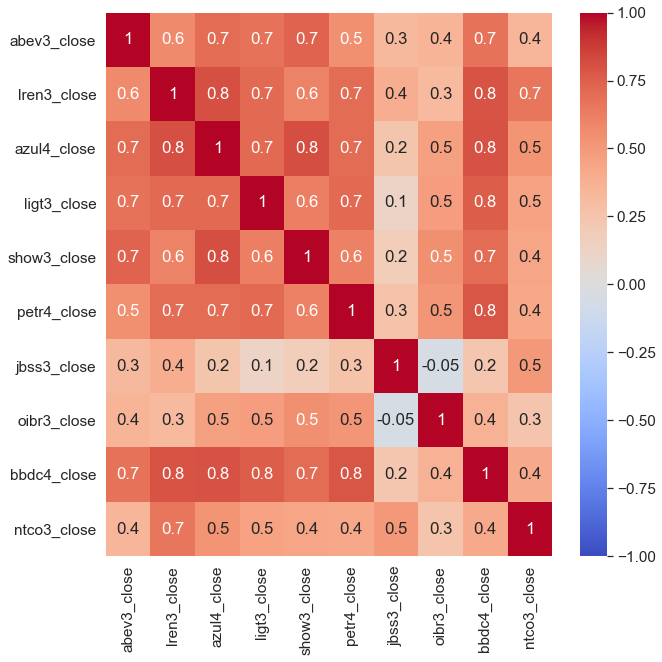

In [152]:
plt.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale=1.4)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',  fmt='.1g', vmin = -1, vmax = 1)

# Decomposing

In [ ]:
same_period.tail()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
multiplicable_result=seasonal_decompose(same_period['abev3_adjusted close'], model='multiplicable', period=12)
additive_result=seasonal_decompose(same_period['abev3_adjusted close'], model='additive', period=12)

In [ ]:
additive_result.trend.plot()

In [ ]:
additive_result.plot()

# Random Portfolio Allocations

In [ ]:
number_of_random_portfolios = 5
random_portfolio_weights = list()

portfolio_return = []
portfoli_risk = []
sharp_ratio = []

for ticker in range(5):
    
    # Creating rando portfolio distributions
    random_weights = np.random.rand(len(to_consider))   
    random_portfolio_weights.append(np.round(random_weights/np.sum(random_weights),3))
    
    

In [ ]:
df.pct_change()